In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from keras.utils import np_utils
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import save_model


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
NB_CLASSES = 4 # number of outputs = number of classes
VERBOSE = 1
BATCH_SIZE = 10
NB_EPOCH = 100
target_names = ['Non-MO', 'MO']
file_short = "D:/BMO/Main/savedModels/20input_model_short.h5"
file_mid1 = "D:/BMO/Main/savedModels/20input_model_mid1.h5"
file_mid2 = "D:/BMO/Main/savedModels/20input_model_mid2.h5"
file_long = "D:/BMO/Main/savedModels/20input_model_long.h5"
file_best = "D:/BMO/Main/savedModels/20input_model_best.h5"

In [3]:
symbol_length =   [1, 128, 1024, 1800, 2048]

In [4]:
%%time

print(".........Loading MO (2-state) dataset..........")

# sep separates each column and header = none means it is going to read from row 1
re2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/real_snr20.csv',sep=',', header=None) 
im2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/im_snr20.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/real_snr20.csv',sep=',', header=None) 
im4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/im_snr20.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/real_snr20.csv',sep=',', header=None) 
im16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/im_snr20.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/real_snr20.csv',sep=',', header=None) 
im64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/im_snr20.csv',sep=',', header=None)

#merge two dataframes into one
df2psk_2st = re2psk_2st + im2psk_2st * 1j
df2psk_2st['Mod'] = 0 # 0 = BPSK 2-state
#merge two dataframes into one
df4psk_2st = re4psk_2st + im4psk_2st * 1j
df4psk_2st['Mod'] = 1 # 1 = QPSK 2-state
#merge two dataframes into one
df16qam_2st = re16qam_2st + im16qam_2st * 1j
df16qam_2st['Mod'] = 2 # 2 = 16-QAM 2-state
#merge two dataframes into one
df64qam_2st = re64qam_2st + im64qam_2st * 1j
df64qam_2st['Mod'] = 3 # 3 = 64-QAM 2-state

# combine all
df_2st = df2psk_2st.append(df4psk_2st)
df_2st = df_2st.append(df16qam_2st)
df_2st = df_2st.append(df64qam_2st)

#df_mo = df_2st
#df_mo = df_mo.sample(frac = 1)
print('df_mo Shape = ', df_2st.shape)

.........Loading MO (2-state) dataset..........
df_mo Shape =  (28000, 2049)
CPU times: total: 44.6 s
Wall time: 44.2 s


In [5]:
print("..........Combining all data..........")

# combine all
#df = df_mo.append(df_nonmo)
df_all = df_2st.sample(frac = 1)
print('df_all Shape = ', df_all.shape)
print("..........Shuffling done..........")

# reducing samples to tune only
#df_all = df_all.iloc[:16384]
print('df_all Size = ', df_all.size)
print('Dimension = ', df_all.ndim)
print('Combined Shape = ', df_all.shape)

..........Combining all data..........
df_all Shape =  (28000, 2049)
..........Shuffling done..........
df_all Size =  57372000
Dimension =  2
Combined Shape =  (28000, 2049)


In [6]:
%%time

f1_bp = []
f1_qp = []
f1_16 = []
f1_64 = []
re_bp = []
re_qp = []
re_16 = []
re_64 = []
pr_bp = []
pr_qp = []
pr_16 = []
pr_64 = []
ac_bp = []
ac_qp = []
ac_16 = []
ac_64 = []

f1mc_bp = []
f1mc_qp = []
f1mc_16 = []
f1mc_64 = []
remc_bp = []
remc_qp = []
remc_16 = []
remc_64 = []
prmc_bp = []
prmc_qp = []
prmc_16 = []
prmc_64 = []
acmc_bp = []
acmc_qp = []
acmc_16 = []
acmc_64 = []

accuracy = []
f1score = []
loss = []
precision = []
false_pos = []
true_pos = []
recall = []

for LENGTH in symbol_length:
    
    # Separating X and y
    y = df_all['Mod'] # 1D targer vector
    X = df_all.drop(columns='Mod')

    INPUT_SHAPE = (LENGTH,1)

    X.drop(X.iloc[:, LENGTH:2048], inplace = True, axis = 1)

    X = np.expand_dims(X, -1)

    # Split into training/testing sets with 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

    print("..........Training set..........")
    print(X_train.shape)
    print(y_train.shape)
    print("..........Validation set..........")
    print(X_val.shape)
    print(y_val.shape)
    print("..........Testing set..........")
    print(X_test.shape)
    print(y_test.shape)

    # Convert class vectors to categorical classes matrices
    y_train = np_utils.to_categorical(y_train, NB_CLASSES)
    y_test = np_utils.to_categorical(y_test, NB_CLASSES)
    y_val = np_utils.to_categorical(y_val, NB_CLASSES)

    from keras.constraints import maxnorm

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        filter_num = ['None',32,64,128,256]
        kernel_size = ['None',8,8,8,8]
        conv_stride_size = ['None',1,1,1,1]
        pool_stride_size = ['None',4,4,4,4]
        pool_size = ['None',8,8,8,8]
        batch_size = 10
        dropout_rate =0.0
        # Feature extraction
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=INPUT_SHAPE,
                             strides=conv_stride_size[1], padding='same',
                             name='convolution1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation1'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                                   padding='same', name='pool1'))
        model.add(Dropout(dropout_rate, name='dropout1'))
        
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation2'))
        model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[2],
                                   padding='same', name='pool2'))
        model.add(Dropout(dropout_rate, name='dropout2'))

        # Output layer
        model.add(Flatten(name='flatten1'))
        model.add(Dense(NB_CLASSES, kernel_initializer=glorot_uniform(seed=0), name='dense1'))
        model.add(Activation('softmax', name="softmax"))

        # Compile model
        model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.6), metrics=["accuracy"])

        return model

    model = create_model()
    # simple early stopping
    es_lr = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc_lr = ModelCheckpoint(file_best, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # fit model
    model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
                                validation_data=(X_val, y_val), callbacks=[es_lr, mc_lr])
  #  model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
   #                             validation_data=(X_val, y_val))
    
    
    if(LENGTH==128):
        save_model(model, file_short)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_short = confusion_matrix(y_test1, y_pred1)
        cmratio_short = cm_short.astype('float') / cm_short.sum(axis=1)[:, np.newaxis]
        cmratio_short= np.around(cmratio_short.astype('float') / cmratio_short.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==512):
        save_model(model, file_mid1)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid1 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid1 = cm_mid1.astype('float') / cm_mid1.sum(axis=1)[:, np.newaxis]
        cmratio_mid1= np.around(cmratio_mid1.astype('float') / cmratio_mid1.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==1536):
        save_model(model, file_mid2)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid2 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid2 = cm_mid2.astype('float') / cm_mid2.sum(axis=1)[:, np.newaxis]
        cmratio_mid2= np.around(cmratio_mid2.astype('float') / cmratio_mid2.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==2048):
        save_model(model, file_long)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_long = confusion_matrix(y_test1, y_pred1)
        cmratio_long = cm_long.astype('float') / cm_long.sum(axis=1)[:, np.newaxis]
        cmratio_long= np.around(cmratio_long.astype('float') / cmratio_long.sum(axis=1)[:, np.newaxis], decimals=1)
        
    # Start evaluating model with testing data
    score_test = model.evaluate(X_test, y_test, verbose=VERBOSE)
    y_pred = model.predict(X_test)
    
    y_pred1=np.argmax(y_pred, axis=1)
    y_test1=np.argmax(y_test, axis=1)
    #cm = confusion_matrix(y_test1, y_pred1
    
    acc = score_test[1]
    accuracy.append(acc)
    
    ls = score_test[0]
    loss.append(ls)
    
    f1s = f1_score(y_test1, y_pred1, average=None)
    f1score.append((f1s[0]+f1s[1])/2)
    print(f1s)
    for index, val in np.ndenumerate(f1s):
            if (index[0]==0): 
                f1bp = val
            if (index[0]==1): 
                f1qp = val
            if (index[0]==2):
                f116 = val
            if (index[0]==3): 
                f164 = val
           
    f1_bp.append(f1bp)
    f1_qp.append(f1qp)
    f1_16.append(f116)
    f1_64.append(f164)
    
    
    cm = confusion_matrix(y_test1, y_pred1)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print('Confusion Matrix when Symbol Length ', LENGTH)
    #f = sns.heatmap(cm, cmap='Greens', annot=True, square=True, yticklabels = True)
    #cmratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #plt.rcParams["figure.figsize"] = (7.5,7.5)
    #plt.rcParams.update({'font.size': 14})
    #f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)
    
    accuracys = cm.diagonal()
    #acc = accuracy.reshape(-1,1)
    print(accuracys)
    for index, val in np.ndenumerate(accuracys):
            if (index[0]==0): 
                abp = val
            if (index[0]==1): 
                aqp = val
            if (index[0]==2):
                a16 = val
            if (index[0]==3): 
                a64 = val
           
    ac_bp.append(abp)
    ac_qp.append(aqp)
    ac_16.append(a16)
    ac_64.append(a64)

..........Training set..........
(20160, 1, 1)
(20160,)
..........Validation set..........
(2240, 1, 1)
(2240,)
..........Testing set..........
(5600, 1, 1)
(5600,)
Epoch 1/100
628/630 [============================>.] - ETA: 0s - loss: 1.3988 - accuracy: 0.2541
Epoch 1: val_accuracy improved from -inf to 0.23616, saving model to D:/BMO/Main/savedModels\20input_model_best.h5
630/630 [==============================] - 2s 2ms/step - loss: 1.3987 - accuracy: 0.2543 - val_loss: 1.3923 - val_accuracy: 0.2362
Epoch 2/100
621/630 [============================>.] - ETA: 0s - loss: 1.3901 - accuracy: 0.2510
Epoch 2: val_accuracy improved from 0.23616 to 0.26741, saving model to D:/BMO/Main/savedModels\20input_model_best.h5
630/630 [==============================] - 1s 1ms/step - loss: 1.3901 - accuracy: 0.2505 - val_loss: 1.3855 - val_accuracy: 0.2674
Epoch 3/100
630/630 [==============================] - ETA: 0s - loss: 1.3902 - accuracy: 0.2507
Epoch 3: val_accuracy did not improve from 0.2674

Epoch 5/100
630/630 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.8987
Epoch 5: val_accuracy did not improve from 0.90670
630/630 [==============================] - 3s 4ms/step - loss: 0.2385 - accuracy: 0.8987 - val_loss: 0.2627 - val_accuracy: 0.8817
Epoch 6/100
629/630 [============================>.] - ETA: 0s - loss: 0.2267 - accuracy: 0.9039
Epoch 6: val_accuracy improved from 0.90670 to 0.91518, saving model to D:/BMO/Main/savedModels\20input_model_best.h5
630/630 [==============================] - 3s 5ms/step - loss: 0.2265 - accuracy: 0.9040 - val_loss: 0.2053 - val_accuracy: 0.9152
Epoch 7/100
628/630 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9035
Epoch 7: val_accuracy did not improve from 0.91518
630/630 [==============================] - 3s 5ms/step - loss: 0.2217 - accuracy: 0.9036 - val_loss: 0.2104 - val_accuracy: 0.9094
Epoch 8/100
620/630 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9095

623/630 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9242
Epoch 33: val_accuracy did not improve from 0.93080
630/630 [==============================] - 3s 4ms/step - loss: 0.1791 - accuracy: 0.9239 - val_loss: 0.2125 - val_accuracy: 0.9161
Epoch 34/100
627/630 [============================>.] - ETA: 0s - loss: 0.1811 - accuracy: 0.9229
Epoch 34: val_accuracy did not improve from 0.93080
630/630 [==============================] - 3s 4ms/step - loss: 0.1817 - accuracy: 0.9227 - val_loss: 0.1676 - val_accuracy: 0.9237
Epoch 35/100
626/630 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9259
Epoch 35: val_accuracy did not improve from 0.93080
630/630 [==============================] - 3s 5ms/step - loss: 0.1757 - accuracy: 0.9259 - val_loss: 0.1985 - val_accuracy: 0.9116
Epoch 36/100
621/630 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9229
Epoch 36: val_accuracy did not improve from 0.93080
630/630 [===========

630/630 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9994
Epoch 10: val_accuracy did not improve from 0.99643
630/630 [==============================] - 15s 24ms/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.0145 - val_accuracy: 0.9946
Epoch 11/100
628/630 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9995
Epoch 11: val_accuracy did not improve from 0.99643
630/630 [==============================] - 15s 24ms/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.0141 - val_accuracy: 0.9960
Epoch 12/100
628/630 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9995
Epoch 12: val_accuracy did not improve from 0.99643
630/630 [==============================] - 15s 24ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0192 - val_accuracy: 0.9929
Epoch 13/100
628/630 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9995
Epoch 13: val_accuracy did not improve from 0.99643
630/630 [=====

629/630 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 38: val_accuracy did not improve from 0.99821
630/630 [==============================] - 14s 23ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9969
Epoch 39/100
630/630 [==============================] - ETA: 0s - loss: 9.9757e-04 - accuracy: 1.0000
Epoch 39: val_accuracy did not improve from 0.99821
630/630 [==============================] - 14s 23ms/step - loss: 9.9757e-04 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 40/100
630/630 [==============================] - ETA: 0s - loss: 9.8293e-04 - accuracy: 1.0000
Epoch 40: val_accuracy did not improve from 0.99821
630/630 [==============================] - 15s 23ms/step - loss: 9.8293e-04 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9960
Epoch 41/100
630/630 [==============================] - ETA: 0s - loss: 9.8281e-04 - accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 0.

630/630 [==============================] - ETA: 0s - loss: 6.1670e-04 - accuracy: 1.0000
Epoch 66: val_accuracy did not improve from 0.99821
630/630 [==============================] - 15s 24ms/step - loss: 6.1670e-04 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9978
Epoch 67/100
628/630 [============================>.] - ETA: 0s - loss: 5.4107e-04 - accuracy: 1.0000
Epoch 67: val_accuracy did not improve from 0.99821
630/630 [==============================] - 15s 25ms/step - loss: 5.4034e-04 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 68/100
630/630 [==============================] - ETA: 0s - loss: 5.2548e-04 - accuracy: 1.0000
Epoch 68: val_accuracy did not improve from 0.99821
630/630 [==============================] - 16s 25ms/step - loss: 5.2548e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9973
Epoch 69/100
629/630 [============================>.] - ETA: 0s - loss: 5.7219e-04 - accuracy: 1.0000
Epoch 69: val_accuracy did not improve

175/175 [==============================] - 1s 7ms/step
[0.99514226 0.99495677 1.         1.        ]
[0.99376299 0.9963925  1.         1.        ]
..........Training set..........
(20160, 1800, 1)
(20160,)
..........Validation set..........
(2240, 1800, 1)
(2240,)
..........Testing set..........
(5600, 1800, 1)
(5600,)
Epoch 1/100
630/630 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.9259
Epoch 1: val_accuracy improved from -inf to 0.99196, saving model to D:/BMO/Main/savedModels\20input_model_best.h5
630/630 [==============================] - 26s 41ms/step - loss: 0.4800 - accuracy: 0.9259 - val_loss: 0.0314 - val_accuracy: 0.9920
Epoch 2/100
630/630 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9944
Epoch 2: val_accuracy improved from 0.99196 to 0.99598, saving model to D:/BMO/Main/savedModels\20input_model_best.h5
630/630 [==============================] - 25s 40ms/step - loss: 0.0231 - accuracy: 0.9944 - val_loss: 0.0170 - val_acc

630/630 [==============================] - ETA: 0s - loss: 6.5699e-04 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 0.99777
630/630 [==============================] - 27s 43ms/step - loss: 6.5699e-04 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9973
Epoch 28/100
630/630 [==============================] - ETA: 0s - loss: 6.5191e-04 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 0.99777
630/630 [==============================] - 28s 44ms/step - loss: 6.5191e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9978
Epoch 29/100
629/630 [============================>.] - ETA: 0s - loss: 6.0144e-04 - accuracy: 1.0000
Epoch 29: val_accuracy improved from 0.99777 to 0.99821, saving model to D:/BMO/Main/savedModels\20input_model_best.h5
630/630 [==============================] - 28s 45ms/step - loss: 6.0067e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9982
Epoch 30/100
629/630 [============================>.] - ETA: 0s - loss: 5

Epoch 55/100
630/630 [==============================] - ETA: 0s - loss: 2.9052e-04 - accuracy: 1.0000
Epoch 55: val_accuracy did not improve from 0.99866
630/630 [==============================] - 40s 64ms/step - loss: 2.9052e-04 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9978
Epoch 56/100
630/630 [==============================] - ETA: 0s - loss: 2.8466e-04 - accuracy: 1.0000
Epoch 56: val_accuracy did not improve from 0.99866
630/630 [==============================] - 40s 64ms/step - loss: 2.8466e-04 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9982
Epoch 57/100
630/630 [==============================] - ETA: 0s - loss: 2.9059e-04 - accuracy: 1.0000
Epoch 57: val_accuracy did not improve from 0.99866
630/630 [==============================] - 40s 63ms/step - loss: 2.9059e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9982
Epoch 58/100
630/630 [==============================] - ETA: 0s - loss: 2.9206e-04 - accuracy: 1.0000
Epoch 58: val_accuracy di

630/630 [==============================] - ETA: 0s - loss: 2.0401e-04 - accuracy: 1.0000
Epoch 83: val_accuracy did not improve from 0.99866
630/630 [==============================] - 37s 59ms/step - loss: 2.0401e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9987
Epoch 84/100
630/630 [==============================] - ETA: 0s - loss: 1.8740e-04 - accuracy: 1.0000
Epoch 84: val_accuracy did not improve from 0.99866
630/630 [==============================] - 45s 71ms/step - loss: 1.8740e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9987
Epoch 85/100
630/630 [==============================] - ETA: 0s - loss: 1.8662e-04 - accuracy: 1.0000
Epoch 85: val_accuracy did not improve from 0.99866
630/630 [==============================] - 47s 75ms/step - loss: 1.8662e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9982
Epoch 86/100
630/630 [==============================] - ETA: 0s - loss: 1.8232e-04 - accuracy: 1.0000
Epoch 86: val_accuracy did not improve

630/630 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.99821
630/630 [==============================] - 29s 46ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9978
Epoch 16/100
630/630 [==============================] - ETA: 0s - loss: 9.3331e-04 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 0.99821
630/630 [==============================] - 29s 45ms/step - loss: 9.3331e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9978
Epoch 17/100
630/630 [==============================] - ETA: 0s - loss: 9.4905e-04 - accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 0.99821
630/630 [==============================] - 29s 46ms/step - loss: 9.4905e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9978
Epoch 18/100
630/630 [==============================] - ETA: 0s - loss: 8.4623e-04 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.

630/630 [==============================] - ETA: 0s - loss: 3.3264e-04 - accuracy: 1.0000
Epoch 43: val_accuracy did not improve from 0.99821
630/630 [==============================] - 44s 70ms/step - loss: 3.3264e-04 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9982
Epoch 44/100
630/630 [==============================] - ETA: 0s - loss: 3.2401e-04 - accuracy: 1.0000
Epoch 44: val_accuracy did not improve from 0.99821
630/630 [==============================] - 44s 69ms/step - loss: 3.2401e-04 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9982
Epoch 45/100
630/630 [==============================] - ETA: 0s - loss: 3.2793e-04 - accuracy: 1.0000
Epoch 45: val_accuracy did not improve from 0.99821
630/630 [==============================] - 44s 70ms/step - loss: 3.2793e-04 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 46/100
630/630 [==============================] - ETA: 0s - loss: 3.0361e-04 - accuracy: 1.0000
Epoch 46: val_accuracy did not improve

Epoch 71/100
630/630 [==============================] - ETA: 0s - loss: 1.9673e-04 - accuracy: 1.0000
Epoch 71: val_accuracy did not improve from 0.99866
630/630 [==============================] - 48s 77ms/step - loss: 1.9673e-04 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9987
Epoch 72/100
630/630 [==============================] - ETA: 0s - loss: 1.9157e-04 - accuracy: 1.0000
Epoch 72: val_accuracy did not improve from 0.99866
630/630 [==============================] - 49s 77ms/step - loss: 1.9157e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9982
Epoch 73/100
630/630 [==============================] - ETA: 0s - loss: 1.7926e-04 - accuracy: 1.0000
Epoch 73: val_accuracy did not improve from 0.99866
630/630 [==============================] - 49s 77ms/step - loss: 1.7926e-04 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 74/100
630/630 [==============================] - ETA: 0s - loss: 1.7900e-04 - accuracy: 1.0000
Epoch 74: val_accuracy di

630/630 [==============================] - ETA: 0s - loss: 1.4132e-04 - accuracy: 1.0000
Epoch 99: val_accuracy did not improve from 0.99866
630/630 [==============================] - 50s 79ms/step - loss: 1.4132e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9987
Epoch 100/100
630/630 [==============================] - ETA: 0s - loss: 1.4291e-04 - accuracy: 1.0000
Epoch 100: val_accuracy did not improve from 0.99866
630/630 [==============================] - 50s 79ms/step - loss: 1.4291e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9982
Saved model to disk
Confusion Matrix when Symbol Length  2048
175/175 [==============================] - 4s 20ms/step
[0.9982669 0.9981969 1.        1.       ]
[0.997921 0.998557 1.       1.      ]
CPU times: total: 10h 32min 7s
Wall time: 2h 36min


In [7]:
print("Symbol series length = ", LENGTH)

y_pred1=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test1, y_pred1)
print(cm)
#f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)

Symbol series length =  2048
[[1440    3    0    0]
 [   2 1384    0    0]
 [   0    0 1354    0]
 [   0    0    0 1417]]


In [8]:
print(accuracy)

[0.2475000023841858, 0.9189285635948181, 0.9975000023841858, 0.9991071224212646, 0.9991071224212646]


[0.2475000023841858, 0.9189285635948181, 0.9975000023841858, 0.9991071224212646, 0.9991071224212646]
[1.3895012140274048, 0.1841098964214325, 0.00696340948343277, 0.003039922099560499, 0.002529356861487031]
[0.0, 0.8424598422804775, 0.9950495173260644, 0.9982318982063361, 0.9982318982063361]


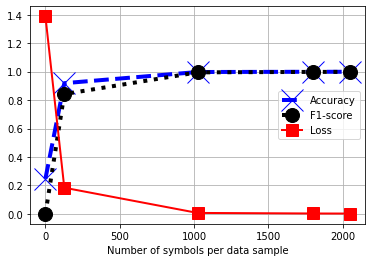

In [9]:
print(accuracy)
print(loss)
print(f1score)
# Plot Graph
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 30})

fig, ax1 = plt.subplots()

ax1.plot(symbol_length, accuracy, color='b', linestyle='dashed', linewidth =4,
         marker='x', markerfacecolor='white', markersize=22, label='Accuracy')
ax1.plot(symbol_length, f1score, color='k', linestyle=':', linewidth =4,
         marker='o', markerfacecolor='k', markersize=14, label='F1-score')
ax1.plot(symbol_length, loss, color='r', linestyle='-', linewidth = 2,
         marker='s', markerfacecolor='r', markersize=12, label='Loss')

ax1.set_xlabel('Number of symbols per data sample')
#ax1.set_ylabel('Score')
plt.grid()
#plt.ylim(0.14, 1.0)
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='center right')

plt.show()